In [1]:
# %load_ext autoreload
# %autoreload 2

In [59]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torchdata
import numpy as np
import datetime as dt

import os
import sys
sys.path.append("../../")

from model.hydro.gr4j_prod import ProductionStorage
from model.utils.training import EarlyStopper
from model.utils.evaluation import evaluate
from data.utils import read_dataset_from_file, get_station_list

In [3]:
data_dir = '../../data/camels/aus/'
sub_dir = 'no-scale-seq'
station_id = '105105A'
run_dir = '../../results/deepgr4j-cnn'

window_size = 10

In [4]:
print(f"Reading data for station_id: {station_id}")
train_ds, val_ds = read_dataset_from_file(data_dir, 
                                          sub_dir, 
                                          station_id=station_id)

Reading data for station_id: 105105A


In [5]:
if not os.path.exists(run_dir):
    os.makedirs(run_dir)

plot_dir = os.path.join(run_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

t_train, X_train, y_train = train_ds.tensors
t_val, X_val, y_val = val_ds.tensors

y_mu = y_train.mean(dim=0)
y_sigma = y_train.std(dim=0)

In [6]:
X_train = torch.nan_to_num(X_train)
X_val = torch.nan_to_num(X_val)


y_train = (y_train - y_mu)/y_sigma
y_val = (y_val - y_mu)/y_sigma


In [7]:
prod_store = ProductionStorage(x1=530.9270033037365)
inp_train = prod_store(X_train, include_x=True)[0]

In [8]:
def create_sequence(X, y, window_size):

        assert window_size is not None, "Window size cannot be NoneType."

        # Create empyty sequences
        Xs, ys = [], []

        # Add sequences to Xs and ys
        for i in range(1, len(X) - window_size):
            Xs.append(torch.concat([
                                    X[i: (i + window_size)], 
                                    y[i-1: (i + window_size - 1)]
                                ], dim=1)
                    )
            ys.append(y[i + window_size - 1])

        Xs, ys = torch.stack(Xs), torch.stack(ys)
        Xs = torch.unsqueeze(Xs, dim=1)

        return Xs, ys

In [9]:
X_train_seq, y_train_seq = create_sequence(inp_train, y_train, 
                                           window_size=window_size)

X_train_seq.shape, y_train_seq.shape

(torch.Size([8386, 1, 10, 10]), torch.Size([8386, 1]))

In [10]:
inp_val = prod_store(X_val, include_x=True)[0]
X_val_seq, y_val_seq = create_sequence(inp_val, y_val, 
                                       window_size=window_size)
X_val_seq.shape, y_val_seq.shape

(torch.Size([3589, 1, 10, 10]), torch.Size([3589, 1]))

In [11]:
train_ds = torchdata.TensorDataset(X_train_seq, y_train_seq)
train_dl = torchdata.DataLoader(train_ds, batch_size=256, shuffle=False)

val_ds = torchdata.TensorDataset(X_val_seq, y_val_seq)
val_dl = torchdata.DataLoader(val_ds, batch_size=256, shuffle=False)

In [12]:
from model.ml import ConvNet
from model.utils.evaluation import evaluate
from tqdm import tqdm

In [47]:
def val_step(model, dl, quantiles):
    total_loss = 0.
    model.eval()
    for j, (X, y) in enumerate(dl, start=1):
        y_hat = model(X)
        batch_loss = 0.
        for j, q in enumerate(quantiles):
            batch_loss += tilted_loss(q, y[:, 0], y_hat[:, j])
        total_loss += batch_loss
    return (total_loss/j).detach()


def train_step(model, dl, quantiles, opt):
    total_loss = 0.
    model.train()
    for i, (X, y) in enumerate(dl, start=1):
        opt.zero_grad()
        y_hat = model(X)
        batch_loss = 0.
        for j, q in enumerate(quantiles):
            batch_loss += tilted_loss(q, y[:, 0], y_hat[:, j])
        total_loss += batch_loss
        batch_loss.backward()
        opt.step()
    return (total_loss/i).detach()

def evaluate_preds(model, ds, batch_size, x_scaler=None, y_scaler=None, quantiles=[0.5]):
    # Evaluate on train data
    model.eval()
    dl = torchdata.DataLoader(ds, 
                              batch_size=batch_size,
                              shuffle=False)

    # Empty list to store batch-wise tensors
    P = []
    ET = []
    Q = []
    Q_hat = []

    for i, (X, y) in enumerate(dl, start=1):
        
        y_hat = model(X)

        Q.append((y*y_sigma+y_mu).detach().numpy())
        Q_hat.append((y_hat*y_sigma+y_mu).detach().numpy())
        

        X_inv = X[:, 0, -1, :-1]*prod_store.sigma+prod_store.mu
        
        P.append((X_inv[:, 0]).detach().numpy())
        ET.append((X_inv[:, 1]).detach().numpy())
    
    P = np.concatenate(P, axis=0)
    ET = np.concatenate(ET, axis=0)
    Q = np.concatenate(Q, axis=0).flatten()
    Q_hat = np.clip(np.concatenate(Q_hat, axis=0), 0, None)

    return evaluate(P, ET, Q, Q_hat, quantiles=quantiles)

In [48]:
in_channels = 1
n_features = 10
n_filters = (16, 16, 8)
dropout = 0.1
quantiles = [0.05, 0.50, 0.95]
n_qualtiles = len(quantiles)

In [49]:
n_epoch = 500
lr = 5e-4

In [50]:
model = ConvNet(n_ts=window_size, 
                n_features=n_features,
                n_channels=in_channels,
                out_dim=n_qualtiles,
                n_filters=n_filters,
                dropout_p=dropout)

In [51]:
from torchsummary import summary
summary(model, (in_channels, window_size, n_features))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 16, 9, 10]              48
            Conv2d-2             [-1, 16, 9, 9]             528
         MaxPool2d-3             [-1, 16, 4, 4]               0
            Conv2d-4              [-1, 8, 3, 3]             520
           Flatten-5                   [-1, 72]               0
           Dropout-6                   [-1, 72]               0
            Linear-7                    [-1, 3]             219
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [52]:
def tilted_loss(q, y, f):
    e = (y-f)
    return torch.mean(torch.maximum(q*e, (q-1)*e))

In [54]:
# Create optimizer and loss instance
opt = torch.optim.Adam(model.parameters(), lr=lr, 
                       betas=(0.89, 0.97), weight_decay=0.02)

# Early stopping
early_stopper = EarlyStopper(patience=10, min_delta=0.01)

pbar = tqdm(range(1, n_epoch+1))

train_loss_list = []

for epoch in pbar:

    # Train step
    train_loss = train_step(model, train_dl, quantiles, opt)

    # Validation step
    val_loss = val_step(model, val_dl, quantiles)
    
    pbar.set_description(f"""Epoch {epoch} loss: {train_loss.numpy():.4f} val_loss: {val_loss.numpy():.4f}""")

    if early_stopper.early_stop(val_loss):
        break

    train_loss_list.append(train_loss.numpy())

Epoch 424 loss: 0.1354 val_loss: 1.0349:  85%|████████▍ | 423/500 [03:39<00:39,  1.93it/s]


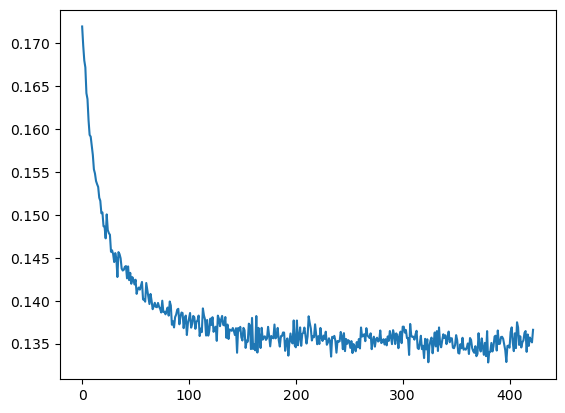

In [62]:

plt.plot(np.arange(len(train_loss_list)), np.array(train_loss_list))

(0.2783842086791992, 0.5808496907621957, <Figure size 1600x600 with 1 Axes>)

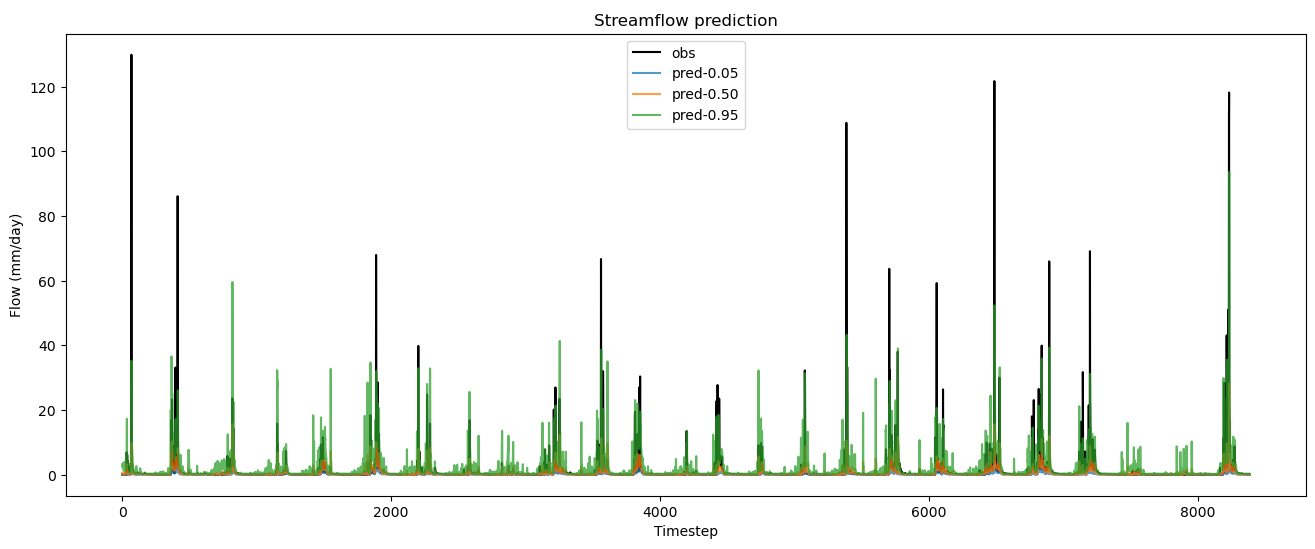

In [38]:
evaluate_preds(model, train_ds, batch_size=256, quantiles=quantiles)

(0.36573076248168945, 0.6118942809683743, <Figure size 1600x600 with 1 Axes>)

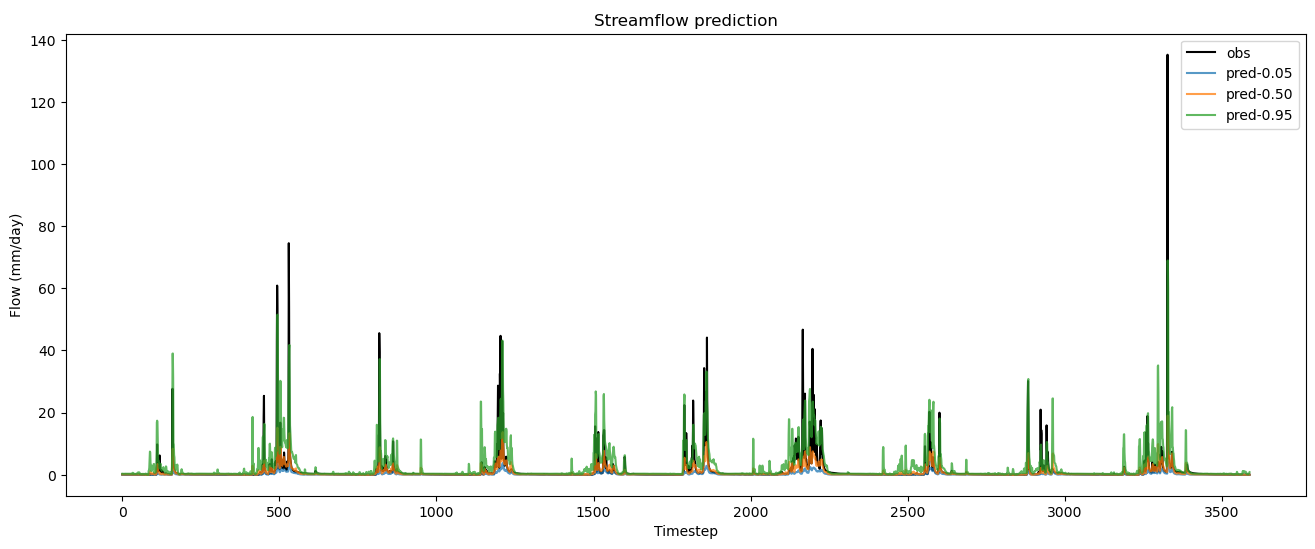

In [39]:
evaluate_preds(model, val_ds, batch_size=256, quantiles=quantiles)